# Basic Strategy

In [34]:
%reload_ext autoreload
%autoreload 2
from init_strategy import generate_basic_strategy
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from env import BaseState, Action
from utils import *



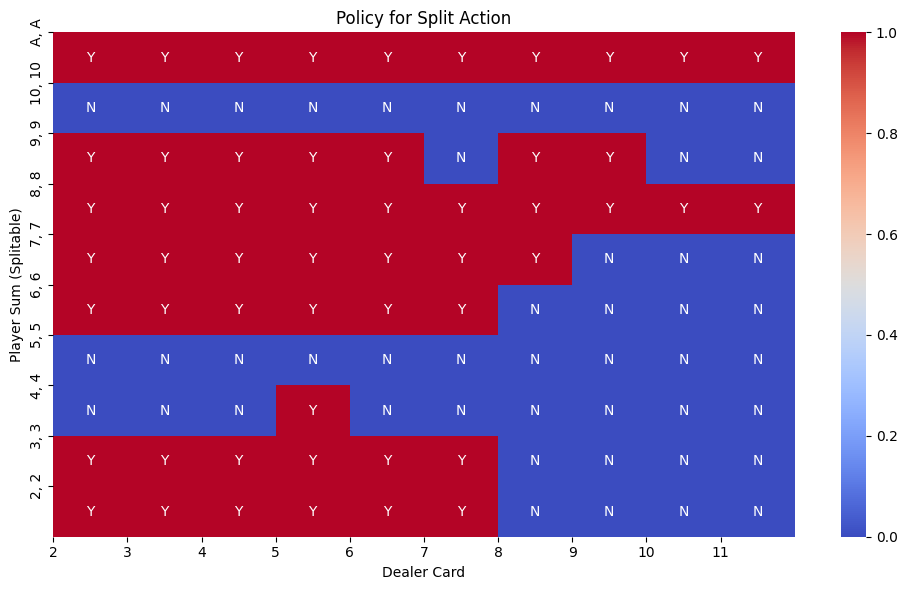

In [35]:
basic_policy = generate_basic_strategy()

# splitting
plot_split_policy(basic_policy)

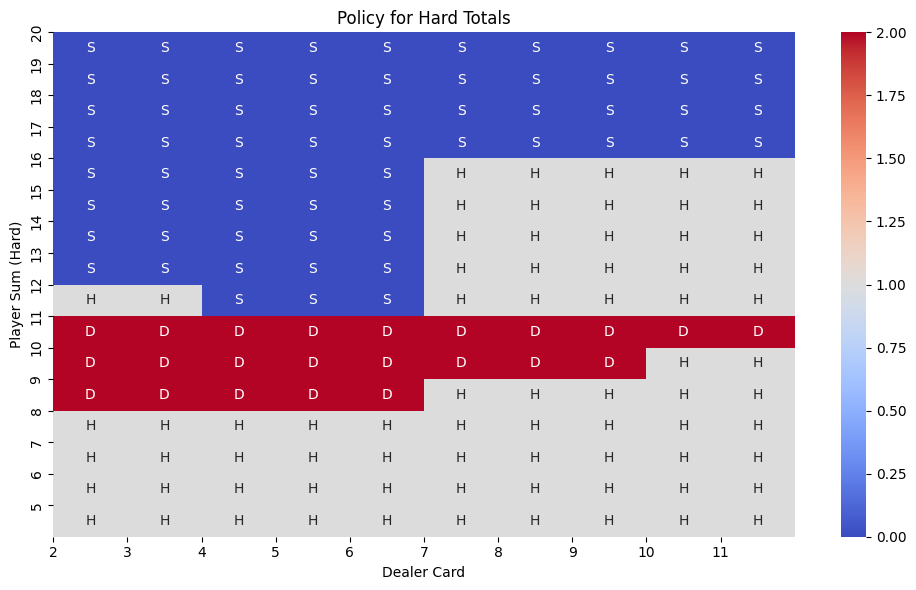

In [36]:
# hard totals
plot_hard_total_policy(basic_policy)

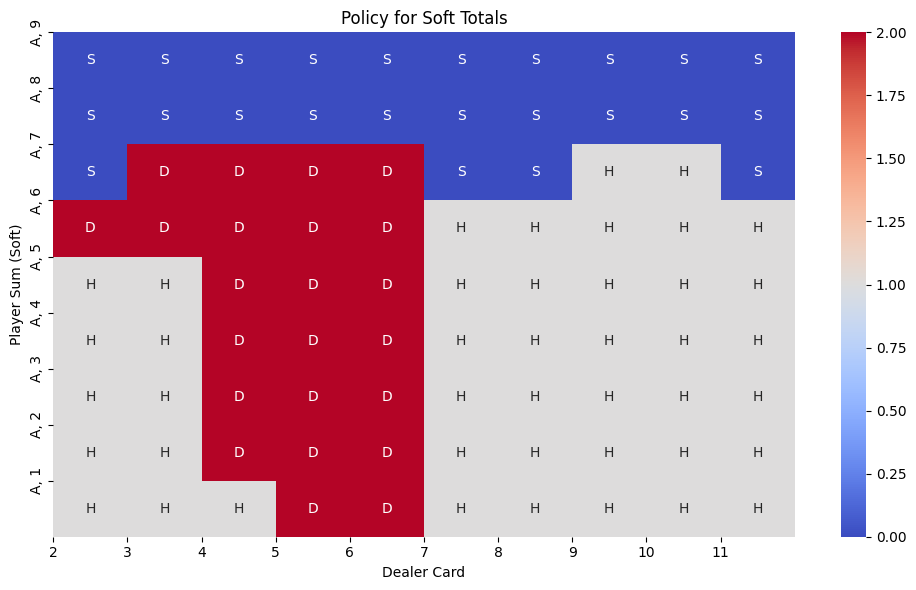

In [37]:
# soft totals
plot_soft_total_policy(basic_policy)

# Load Trained Q and Policy

In [ ]:
import pickle

agent_name = "MCE_double_all"

save_path = f"results/agent_{agent_name}"

with open(f"{save_path}/policy.pkl", "rb") as f:
    policy = pickle.load(f)
with open(f"{save_path}/Q.pkl", "rb") as f:
    Q = pickle.load(f)

print(policy)
print(Q)

# for s, a in Q:
#     print(f"State: {s}, Action: {a}, Q-value: {Q[(s, a)]}")

# for s in policy:
#     print(f"State: {s}, Action: {policy[s]}")

{BaseState(player_sum=9, dealer_card=8, usible_ace=False, splitable=False, can_double=True): <Action.Double: 2>, BaseState(player_sum=13, dealer_card=8, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=16, dealer_card=8, usible_ace=True, splitable=False, can_double=True): <Action.Hit: 1>, BaseState(player_sum=21, dealer_card=8, usible_ace=True, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=9, dealer_card=3, usible_ace=False, splitable=False, can_double=True): <Action.Double: 2>, BaseState(player_sum=14, dealer_card=3, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=10, dealer_card=9, usible_ace=False, splitable=False, can_double=True): <Action.Double: 2>, BaseState(player_sum=13, dealer_card=9, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=13, dealer_card=11, usible_ace=False, splitable=False, can_double=True): <Action.

# Show Optimal Policy
## Split Policy

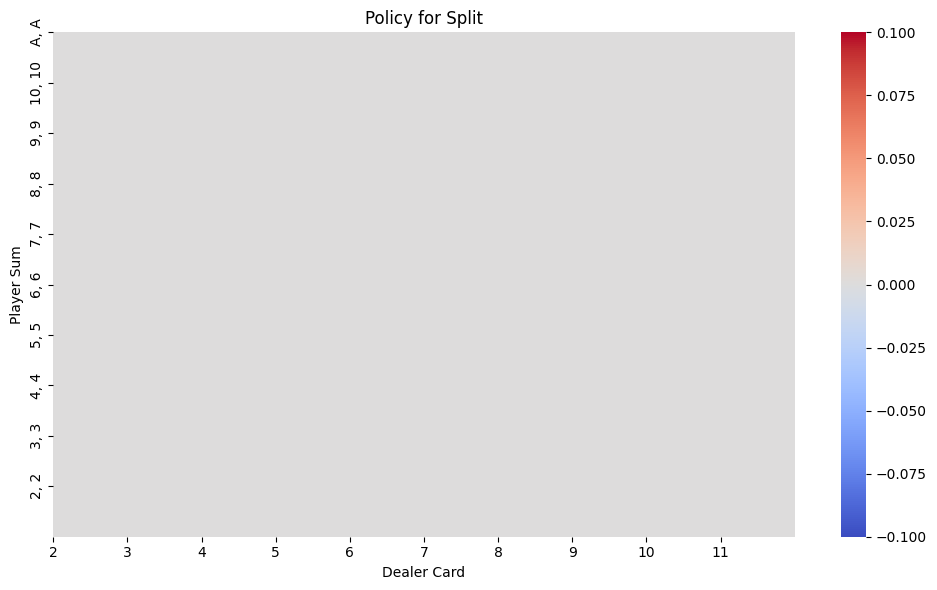

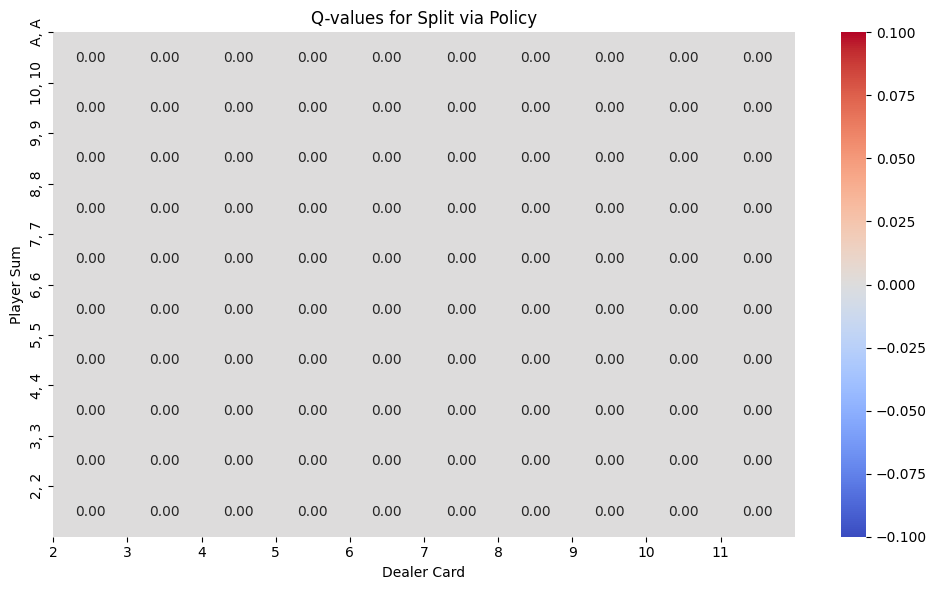

In [39]:
# plot_split_policy(policy)
plot_policy_and_Q(Q,policy, ChartName.Split, True)

## Soft Totals
Player has soft Ace

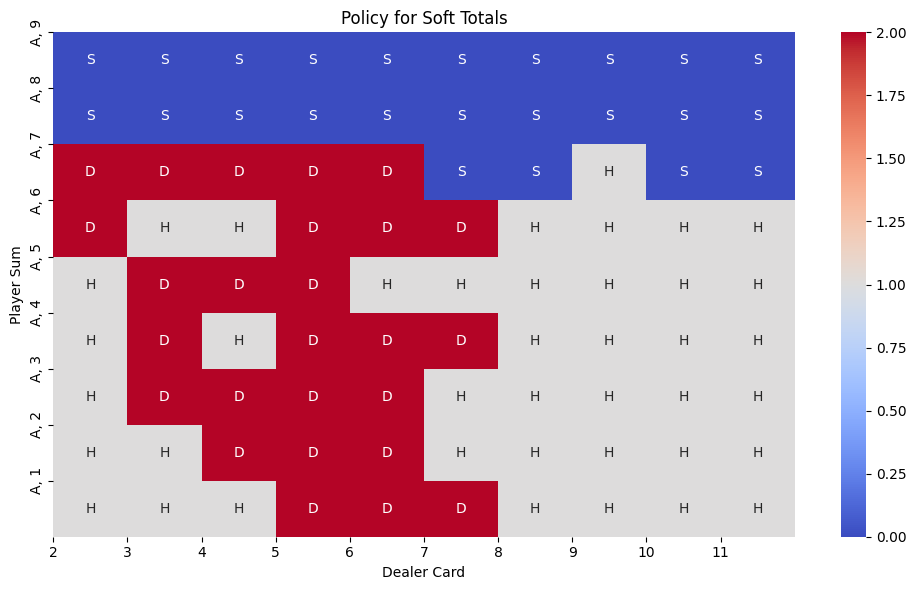

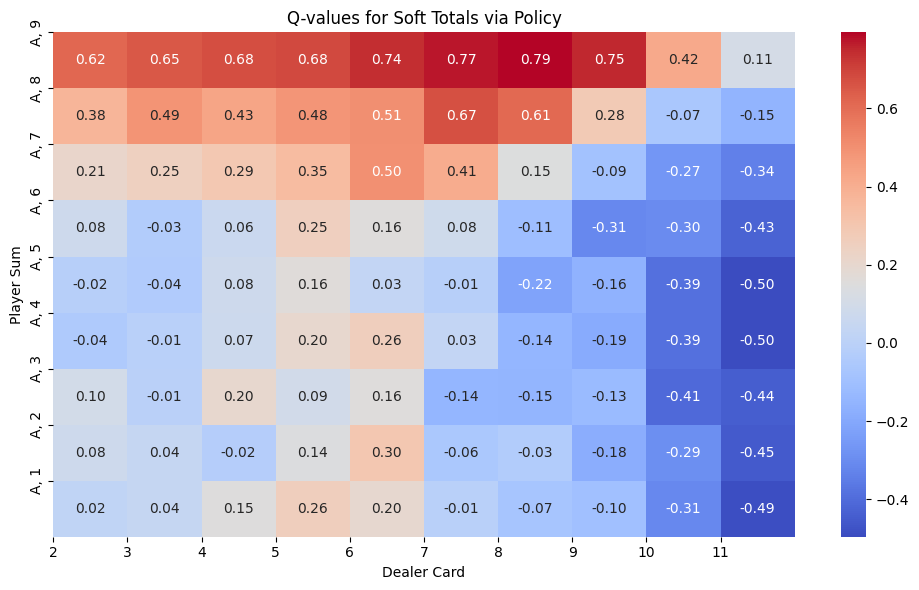

In [40]:
plot_policy_and_Q(Q,policy, ChartName.SoftTotals, can_double=True)

# Hard Totals

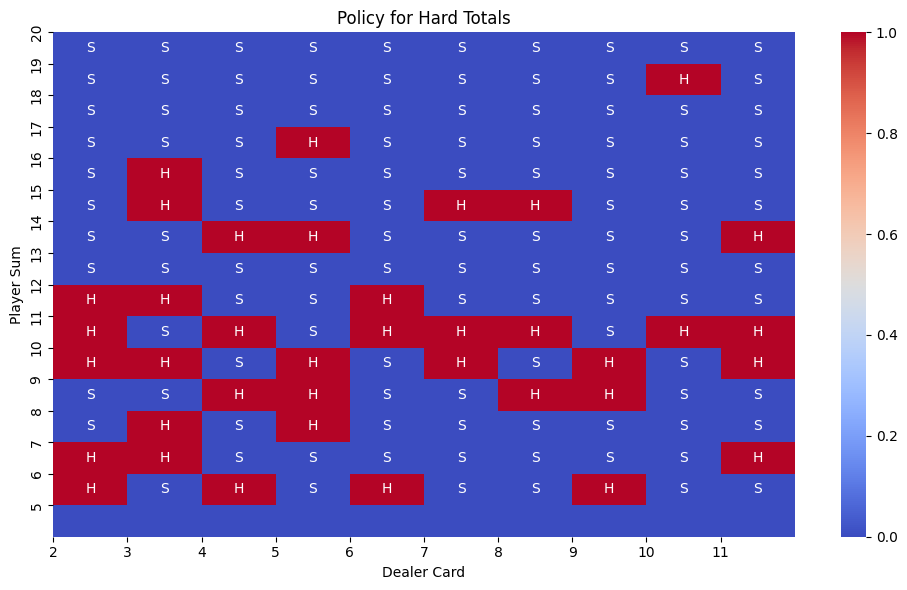

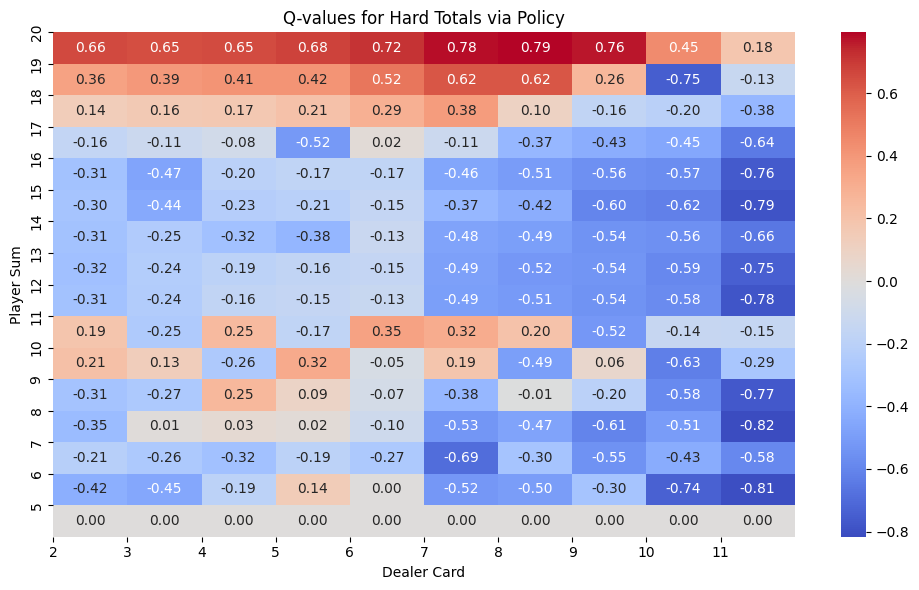

In [41]:
plot_policy_and_Q(Q, policy, ChartName.HardTotals,can_double=False)